# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to each match

Data that we obtained for each player:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.9307224848075625

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.93      7416
         Win       0.93      0.93      0.93      7394

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results


* Decision Tress is still our best model, although adding this data decreased our performance to be about 1.5% (without match history). Our accuracy for losses are down to 91.7% now with lower recall by about 2% for both wins and losses and total f1 score decrease by 1% for both as well
```
Model Score: 0.9195138419986496

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```


* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Decrease in accuracy for KNN and Random Forest


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-history_raw"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018


LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

# drop all matchup columns
matchup_columns = [col for col in X_train.columns if re.search('matchup', col)]
print(f'Before: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')
X_train = X_train.drop(matchup_columns, axis=1)
X_test = X_test.drop(matchup_columns, axis=1)

# drop all history columns that doesn't have percentage or diff
history_columns = [col for col in X_train.columns if re.search('history.+(percentage|diff)', col)]
X_train = X_train.drop(history_columns, axis=1)
X_test = X_test.drop(history_columns, axis=1)


print(f'After: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')

Before: X_train.shape (44429, 5293) X_test.shape (14810, 5293)
After: X_train.shape (44429, 5265) X_test.shape (14810, 5265)


These are the history columns that we kept

In [4]:
[col for col in X_train.columns if re.search('history', col)]

['p1_history_games_lost',
 'p1_history_games_won',
 'p1_history_losses',
 'p1_history_sets_lost',
 'p1_history_sets_won',
 'p1_history_wins',
 'p2_history_games_lost',
 'p2_history_games_won',
 'p2_history_losses',
 'p2_history_sets_lost',
 'p2_history_sets_won',
 'p2_history_wins',
 'p1_history_matches',
 'p2_history_matches']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6728561782579339

              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.67      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4945  2508
Win   2337  5020


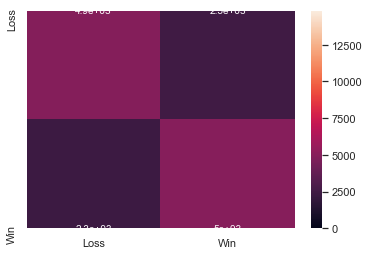

In [6]:
lr.analyze()

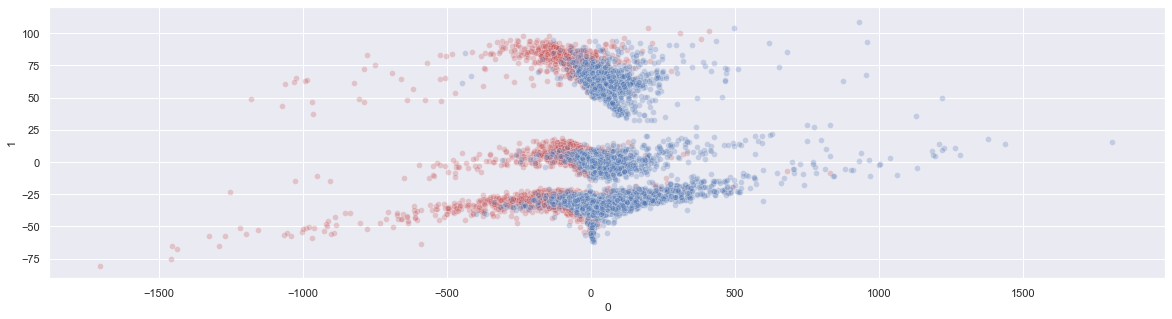

In [7]:
ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8074274139095206

              precision    recall  f1-score   support

        Loss       0.80      0.83      0.81      7453
         Win       0.82      0.78      0.80      7357

    accuracy                           0.81     14810
   macro avg       0.81      0.81      0.81     14810
weighted avg       0.81      0.81      0.81     14810

      Loss   Win
Loss  6192  1261
Win   1591  5766


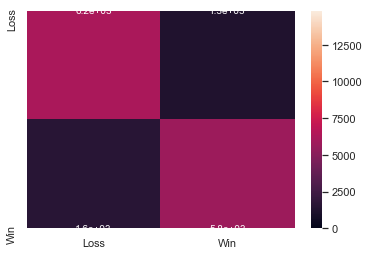

In [10]:
knn.analyze()

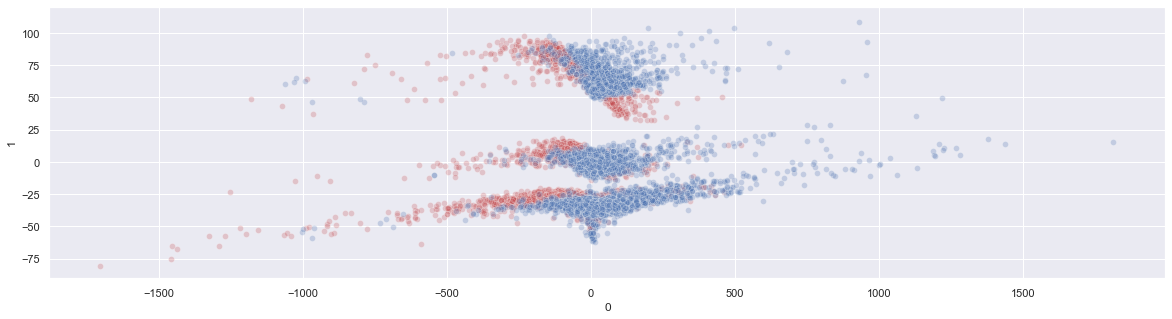

In [11]:
ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9203916272788656

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810

      Loss   Win
Loss  6892   561
Win    618  6739


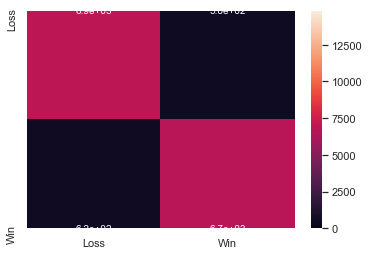

In [14]:
dt.analyze()

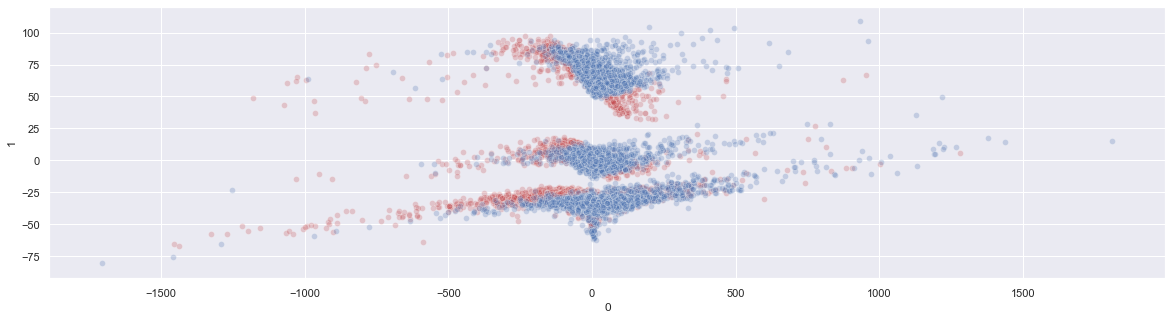

In [15]:
ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.774949358541526

              precision    recall  f1-score   support

        Loss       0.76      0.81      0.78      7453
         Win       0.80      0.74      0.76      7357

    accuracy                           0.77     14810
   macro avg       0.78      0.77      0.77     14810
weighted avg       0.78      0.77      0.77     14810

      Loss   Win
Loss  6059  1394
Win   1939  5418


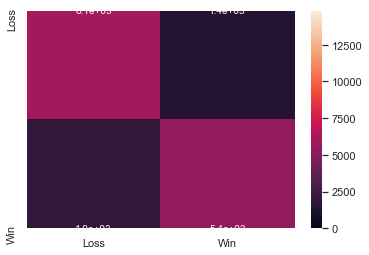

In [18]:
rf.analyze()

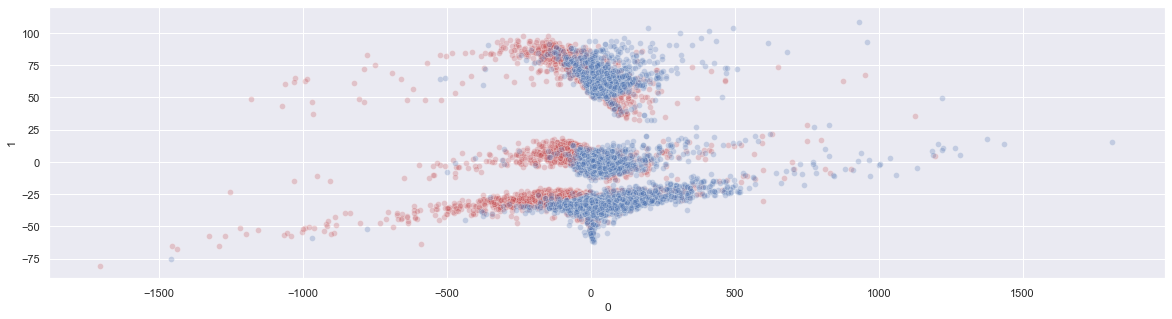

In [19]:
ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157            9.43m
         2           1.2579            9.81m
         3           1.2102            9.67m
         4           1.1722            9.38m
         5           1.1405            9.22m
         6           1.1058            9.06m
         7           1.0785            8.95m
         8           1.0558            8.82m
         9           1.0321            8.68m
        10           1.0159            8.54m
        20           0.8899            7.43m
        30           0.8228            6.43m
        40           0.7862            5.48m
        50           0.7601            4.54m
        60           0.7463            3.64m
        70           0.7247            2.74m
        80           0.7061            1.83m
        90           0.6882           55.01s
       100           0.6808            0.00s


Model Score: 0.8538825118163403

              precision    recall  f1-score   support

        Loss       0.84      0.88      0.86      7453
         Win       0.87      0.83      0.85      7357

    accuracy                           0.85     14810
   macro avg       0.85      0.85      0.85     14810
weighted avg       0.85      0.85      0.85     14810

      Loss   Win
Loss  6522   931
Win   1233  6124


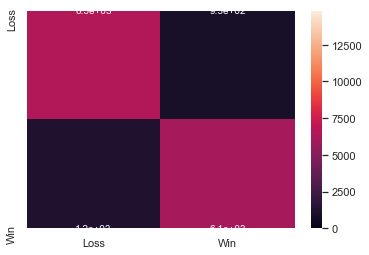

In [22]:
gb.analyze()

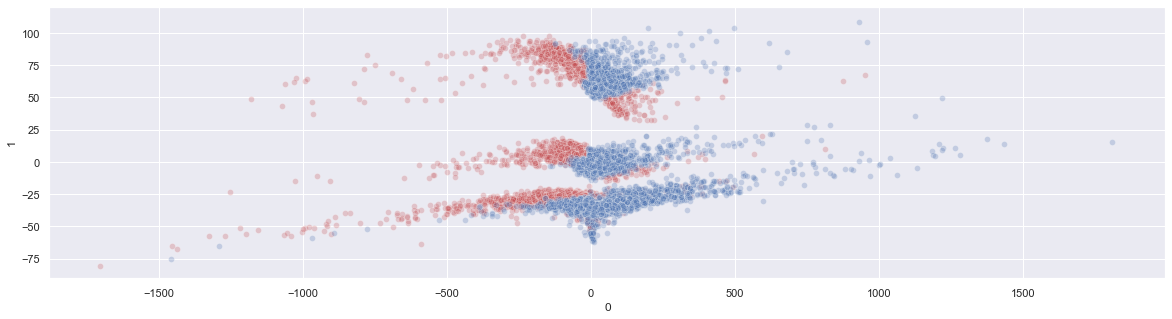

In [23]:
ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7492910195813639

              precision    recall  f1-score   support

        Loss       0.74      0.78      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5847  1606
Win   2107  5250


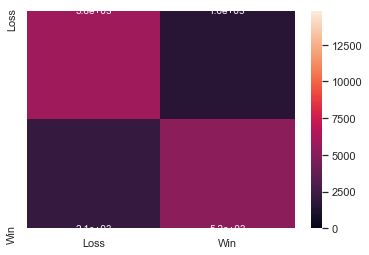

In [26]:
ab.analyze()

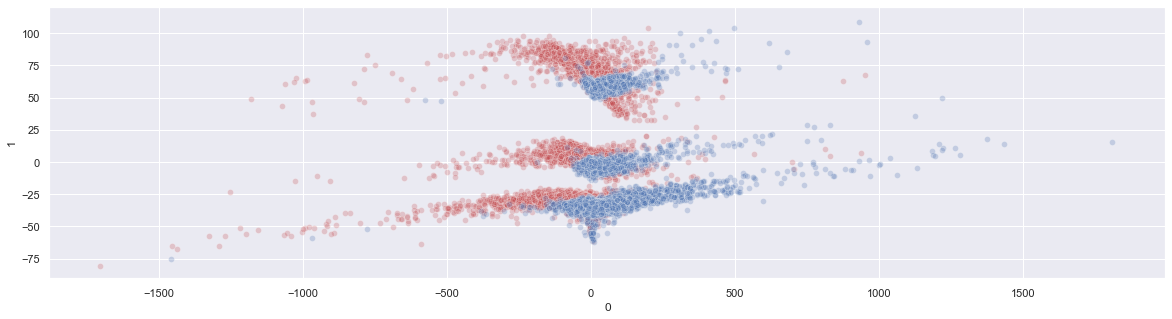

In [27]:
ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [2]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,accuracy,classification_report,confusion_matrix,data_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,start_year,total_time_min
49,0.807427,"{""Loss"": {""precision"": 0.7955801104972375, ""re...","{""0"": {""0"": 6192, ""1"": 1591}, ""1"": {""0"": 1261,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-history_raw,2018,0.0,../models/kneighborsclassifier-1998-2018-diff-...,KNeighborsClassifier,1.0,1998,1.0
50,0.920392,"{""Loss"": {""precision"": 0.9177097203728363, ""re...","{""0"": {""0"": 6892, ""1"": 618}, ""1"": {""0"": 561, ""...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-history_raw,2018,0.0,../models/decisiontreeclassifier-1998-2018-dif...,DecisionTreeClassifier,0.0,1998,0.0
51,0.774949,"{""Loss"": {""precision"": 0.7575643910977744, ""re...","{""0"": {""0"": 6059, ""1"": 1939}, ""1"": {""0"": 1394,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-history_raw,2018,0.0,../models/randomforestclassifier-1998-2018-dif...,RandomForestClassifier,0.0,1998,0.0
52,0.853883,"{""Loss"": {""precision"": 0.8410058027079303, ""re...","{""0"": {""0"": 6522, ""1"": 1233}, ""1"": {""0"": 931, ...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-history_raw,2018,9.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,1998,9.0
53,0.749291,"{""Loss"": {""precision"": 0.735101835554438, ""rec...","{""0"": {""0"": 5847, ""1"": 2107}, ""1"": {""0"": 1606,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-history_raw,2018,1.0,../models/adaboostclassifier-1998-2018-diff-oh...,AdaBoostClassifier,0.0,1998,1.0


Text(0.5, 1.0, 'Model Accuracy')

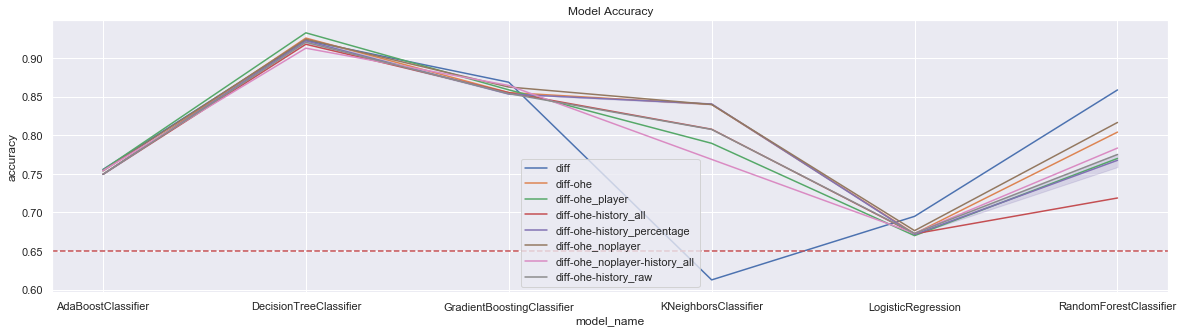

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 5))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")

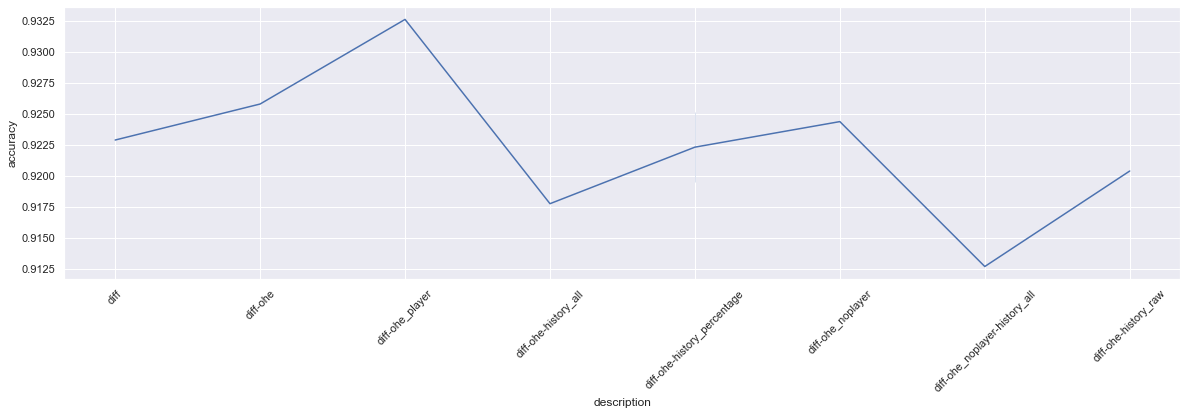

In [17]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


(2, 14810, 5265)


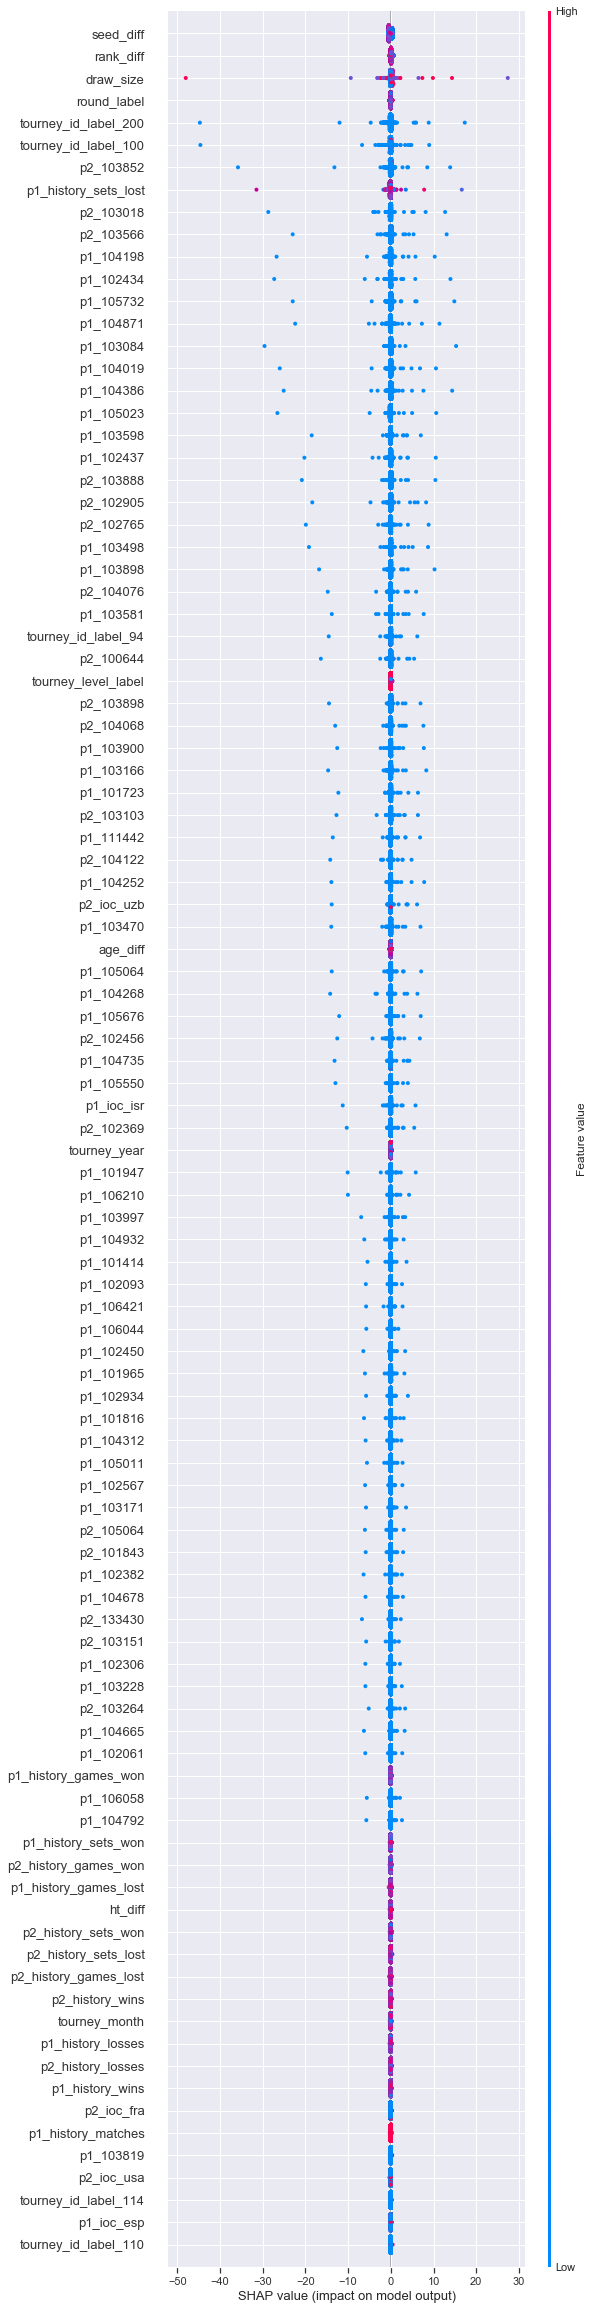

In [31]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(dt.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)

shap.summary_plot(shap_values[1], X_test, max_display=100)


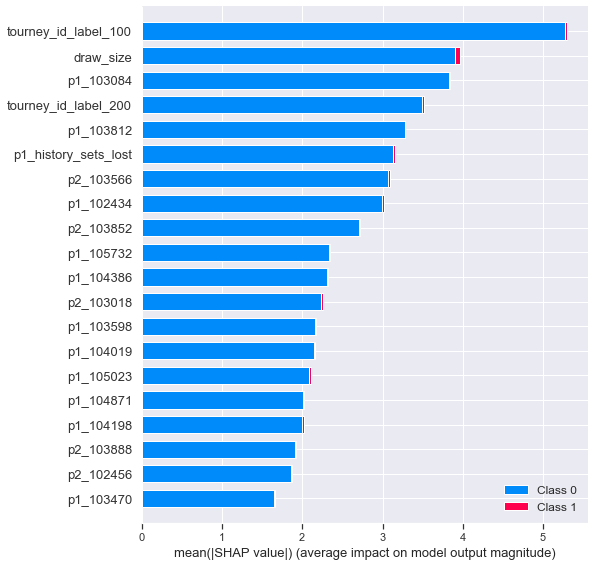

In [32]:
shap.summary_plot(shap_values, feature_names=X_test.columns, title="Feature Importance")

In [33]:
print('Expected Value:', explainer.expected_value)

Expected Value: [0.49771544337272644, 0.5022845268249512]
